In [78]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')
from stargazer.stargazer import Stargazer

import mpl

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [79]:
os.chdir(processed)
df = pd.read_csv('data.csv')

df = df.query('Y >= 1994').query('Y <= 1996')
df['post'] = df['Y'] == 1996
df

/tmp/ipykernel_2237550/1874065039.py:2: DtypeWarning: Columns (70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,terceros,pago_tar,deudas,monedas,casas,balance,otra_ero,clase_hog,nom_emp,post
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,19940110060,1001,153,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20541,19963399020,15033,1351,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20542,19963399030,15033,1351,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20543,19963399040,15033,1351,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20544,19963399060,15109,1077,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [80]:
consumption = pd.read_csv('consumption_guntin.csv')
consumption = consumption.drop(columns='Y')
consumption = consumption.rename(columns={'consumption':'gconsumption'})
consumption

,hhid,gconsumption
0,19940110010,2654.97
1,19940110020,1518.45
2,19940110030,1342.65
3,19940110040,2499.01
4,19940110050,2486.50
...,...,...
26777,19963399040,1346.55
26778,19963399050,2470.58
26779,19963399060,3976.13
26780,19963399500,2701.78


In [81]:
df = df.merge(consumption, on=['hhid'], how='inner')

In [82]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])
df = df.merge(cpi, on='Y', how='inner')

In [83]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

income = ['income_salary', 'income_business', 'income_transfers']
#income = ['income_real']
df['income'] = df[income].sum(axis=1)
df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

consumption = ['gconsumption']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal', 'consumption_education']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
df = df.query('relationship_to_hhm == 1')
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 60')
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [85]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]

In [86]:
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = utils.get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
    

In [87]:
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')
df

,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,clase_hog,nom_emp,post,gconsumption,cpi,income,log_income,consumption,log_consumption,decile
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,False,2654.97,19.551304,36.826188,3.606209,15.088337,2.713922,3
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,False,1342.65,19.551304,47.055685,3.851332,22.891056,3.130746,5
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,False,2499.01,19.551304,56.262232,4.030023,21.303012,3.058848,5
3,19940110060,1001,153,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,NaN,False,2645.51,19.551304,77.334995,4.348147,27.062236,3.298139,7
4,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,False,5542.78,19.551304,110.819548,4.707903,47.249875,3.855450,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13026,19963399020,15033,1351,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,NaN,True,3381.49,35.467989,33.833325,3.521446,23.834802,3.171147,4
13027,19963399030,15033,1351,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,NaN,True,2232.24,35.467989,20.793398,3.034636,15.734188,2.755836,2
13028,19963399040,15033,1351,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,NaN,True,1346.55,35.467989,10.673609,2.367774,5.423603,1.690760,1
13029,19963399060,15109,1077,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,NaN,True,3976.13,35.467989,49.622210,3.904439,37.368250,3.620821,6


In [88]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [89]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

In [90]:
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = ' post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
#income_reg = 'log_income ~ ' + Z 
#income_model = smf.wls(income_reg, df, weights=df['weight']).fit()
income_model = smf.glm(income_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_income_resid'] = income_model.resid

In [91]:
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = 'post:C(education) + post:C(sex)'

consumption_reg = 'log_consumption ~ ' + Z + '+' + D
#income_reg = 'log_consumption ~ ' + Z 
#consumption_model = smf.wls(consumption_reg, df, weights=df['weight']).fit()
consumption_model = smf.glm(consumption_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_consumption_resid'] = consumption_model.resid

In [92]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        log_consumption   No. Observations:                13031
Model:                            GLM   Df Residuals:                 23191150
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                         0.16930
Method:                          IRLS   Log-Likelihood:            -1.2312e+07
Date:                Wed, 29 Nov 2023   Deviance:                   3.9263e+06
Time:                        17:56:18   Pearson chi2:                 3.93e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.9387      0.002   1704.400      0.000       2.935       2.942
C(sex)[T.2]                             0.0593      0.000    167.285      0.000       0.059       0.060
C(education)[T.low]                    -0.0883      0.000   -207.147      0.000      -0.089      -0.087
C(education)[T.medium]                 -0.0409      0.000   -100.339      0.000      -0.042      -0.040
C(location_size)[T.2]                  -0.0577      0.000   -247.513      0.000      -0.058      -0.057
C(location_size)[T.3]                  -0.0888      0.000   -354.208      0.000      -0.089      -0.088
C(decile)[T.2]                          0.3498      0.001    629.228      0.000       0.349       0.351
C(decile)[T.3]                          0.5479      0.001    984.678      0.000       0.547       0.549
C(decile)[T.4]                          0.7109      0.001   1269.033      0.000       0.710       0.712
C(decile)[T.5]                          0.8037      0.001   1420.829      0.000       0.803       0.805
C(decile)[T.6]                          0.9813      0.001   1735.363      0.000       0.980       0.982
C(decile)[T.7]                          1.0970      0.001   1918.174      0.000       1.096       1.098
C(decile)[T.8]                          1.2830      0.001   2219.472      0.000       1.282       1.284
C(decile)[T.9]                          1.5822      0.001   2683.304      0.000       1.581       1.583
C(decile)[T.10]                         2.0813      0.001   3320.726      0.000       2.080       2.082
post[T.True]:C(decile)[1]              -0.2647      0.001   -343.840      0.000      -0.266      -0.263
post[T.True]:C(decile)[2]              -0.2144      0.001   -280.678      0.000      -0.216      -0.213
post[T.True]:C(decile)[3]              -0.2004      0.001   -265.003      0.000      -0.202      -0.199
post[T.True]:C(decile)[4]              -0.2042      0.001   -273.174      0.000      -0.206      -0.203
post[T.True]:C(decile)[5]              -0.1486      0.001   -203.278      0.000      -0.150      -0.147
post[T.True]:C(decile)[6]              -0.2150      0.001   -294.318      0.000      -0.216      -0.214
post[T.True]:C(decile)[7]              -0.1251      0.001   -177.257      0.000      -0.126      -0.124
post[T.True]:C(decile)[8]              -0.1218      0.001   -178.719      0.000      -0.123      -0.120
post[T.True]:C(decile)[9]              -0.2341      0.001   -363.943      0.000      -0.235      -0.233
post[T.True]:C(decile)[10]             -0.2388      0.001   -417.507      0.000      -0.240      -0.238
post[T.True]:C(education)[T.low]        0.0314      0.001     53.674      0.000       0.030       0.033
post[T.True]:C(education)[T.medium]     0.0372      0.001     66.12

In [93]:
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                13031
Model:                            GLM   Df Residuals:                 23191150
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                        0.045364
Method:                          IRLS   Log-Likelihood:             2.9587e+06
Date:                Wed, 29 Nov 2023   Deviance:                   1.0520e+06
Time:                        17:56:18   Pearson chi2:                 1.05e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.8544      0.001   3198.241      0.000       2.853       2.856
C(sex)[T.2]                            -0.0268      0.000   -145.876      0.000      -0.027      -0.026
C(education)[T.low]                    -0.0687      0.000   -311.489      0.000      -0.069      -0.068
C(education)[T.medium]                 -0.0601      0.000   -284.914      0.000      -0.061      -0.060
C(location_size)[T.2]                  -0.0193      0.000   -159.634      0.000      -0.020      -0.019
C(location_size)[T.3]                  -0.0460      0.000   -354.212      0.000      -0.046      -0.046
C(decile)[T.2]                          0.5223      0.000   1815.119      0.000       0.522       0.523
C(decile)[T.3]                          0.7908      0.000   2745.654      0.000       0.790       0.791
C(decile)[T.4]                          1.0189      0.000   3513.710      0.000       1.018       1.019
C(decile)[T.5]                          1.2255      0.000   4185.224      0.000       1.225       1.226
C(decile)[T.6]                          1.4405      0.000   4921.022      0.000       1.440       1.441
C(decile)[T.7]                          1.6723      0.000   5648.889      0.000       1.672       1.673
C(decile)[T.8]                          1.9704      0.000   6585.136      0.000       1.970       1.971
C(decile)[T.9]                          2.3606      0.000   7734.213      0.000       2.360       2.361
C(decile)[T.10]                         3.1370      0.000   9669.244      0.000       3.136       3.138
post[T.True]:C(decile)[1]              -0.3319      0.000   -832.900      0.000      -0.333      -0.331
post[T.True]:C(decile)[2]              -0.3018      0.000   -763.020      0.000      -0.303      -0.301
post[T.True]:C(decile)[3]              -0.2815      0.000   -719.188      0.000      -0.282      -0.281
post[T.True]:C(decile)[4]              -0.2867      0.000   -740.967      0.000      -0.287      -0.286
post[T.True]:C(decile)[5]              -0.2849      0.000   -752.877      0.000      -0.286      -0.284
post[T.True]:C(decile)[6]              -0.2888      0.000   -763.677      0.000      -0.290      -0.288
post[T.True]:C(decile)[7]              -0.2965      0.000   -811.698      0.000      -0.297      -0.296
post[T.True]:C(decile)[8]              -0.3354      0.000   -951.047      0.000      -0.336      -0.335
post[T.True]:C(decile)[9]              -0.3384      0.000  -1016.340      0.000      -0.339      -0.338
post[T.True]:C(decile)[10]             -0.3614      0.000  -1220.295      0.000      -0.362      -0.361
post[T.True]:C(education)[T.low]       -0.0065      0.000    -21.556      0.000      -0.007      -0.006
post[T.True]:C(education)[T.medium]    -0.0057      0.000    -19.46

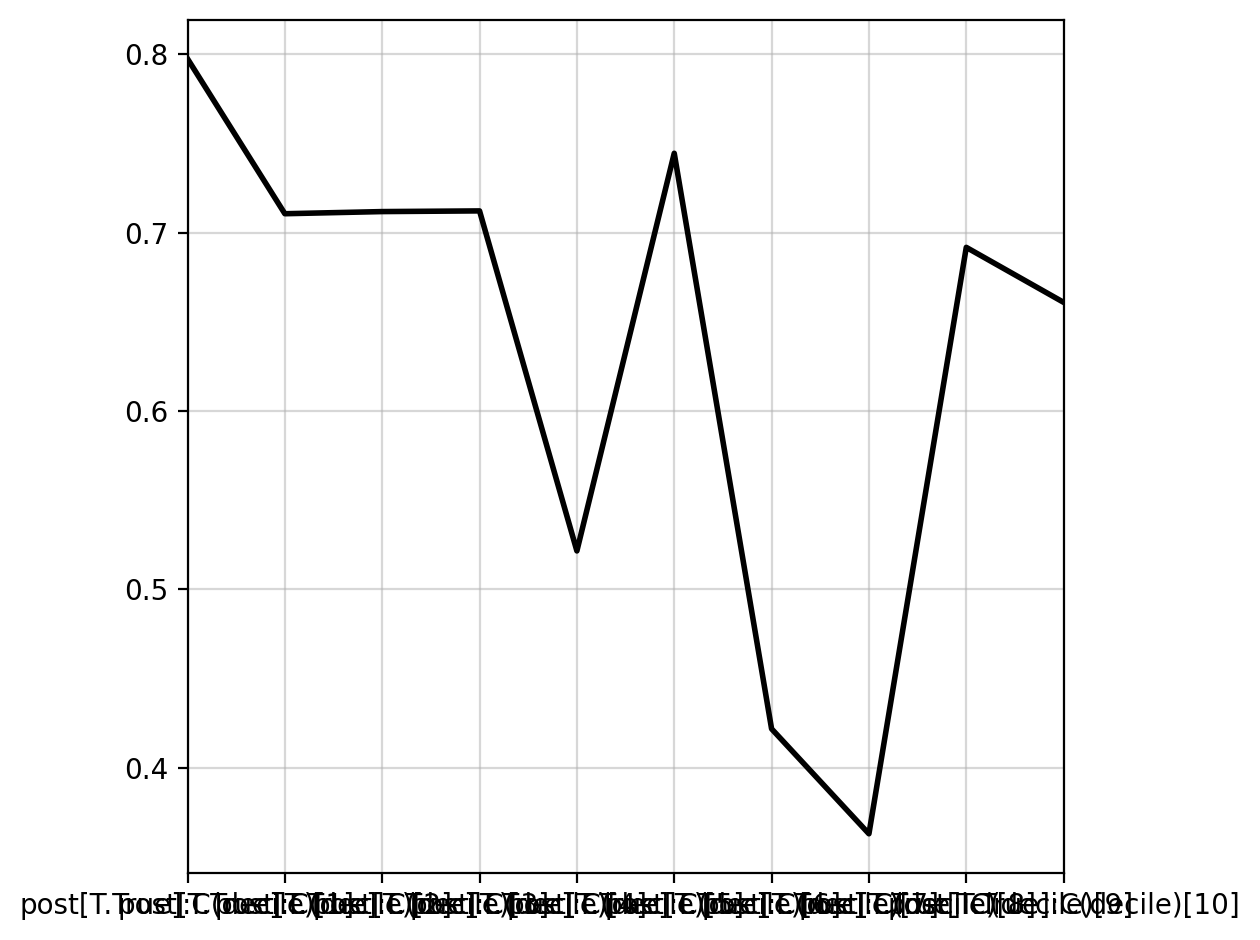

In [94]:
plt.clf()
plt.plot(consumption_model.params[params] / income_model.params[params])
plt.show()

In [95]:
nboot = 1000
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    # matters alot: double vs single resampling of the data
    # something tells me single sampling is correct
    # this is correct because: are matching the samples of the original data 
    # so should be all set 
    data_boot = df.copy().sample(len(data), weights=df['weight'], replace=True, axis=0)
    #data_boot = df.copy().sample(len(data), replace=True, axis=0)

    #consumption_model = smf.wls(consumption_reg, data_boot, weights=data_boot['weight']).fit()
    #consumption_model = smf.glm(consumption_reg, data_boot, freq_weights=data_boot['weight'], missing='drop', family=fam).fit()
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=fam).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    #income_model = smf.wls(income_reg, data_boot, weights=data_boot['weight']).fit()
    #income_model = smf.glm(income_reg, data_boot, freq_weights=data_boot['weight'],  missing='drop', family=fam).fit()
    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=fam).fit()
    dincome[boot, :] = income_model.params[params]


In [96]:
dincome

array([[-0.31789515, -0.30309892, -0.27881686, ..., -0.34258962,
        -0.33628719, -0.41932178],
       [-0.31910677, -0.2695657 , -0.25476666, ..., -0.31867935,
        -0.34012149, -0.32958056],
       [-0.3697615 , -0.31625021, -0.31489498, ..., -0.34548848,
        -0.35674026, -0.36309011],
       ...,
       [-0.27408341, -0.26373182, -0.25866864, ..., -0.30470442,
        -0.33153245, -0.30328708],
       [-0.29936926, -0.28690259, -0.27478646, ..., -0.32944743,
        -0.33741054, -0.35985415],
       [-0.41290686, -0.32194293, -0.29966112, ..., -0.33141067,
        -0.32338686, -0.30524933]])

In [97]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]


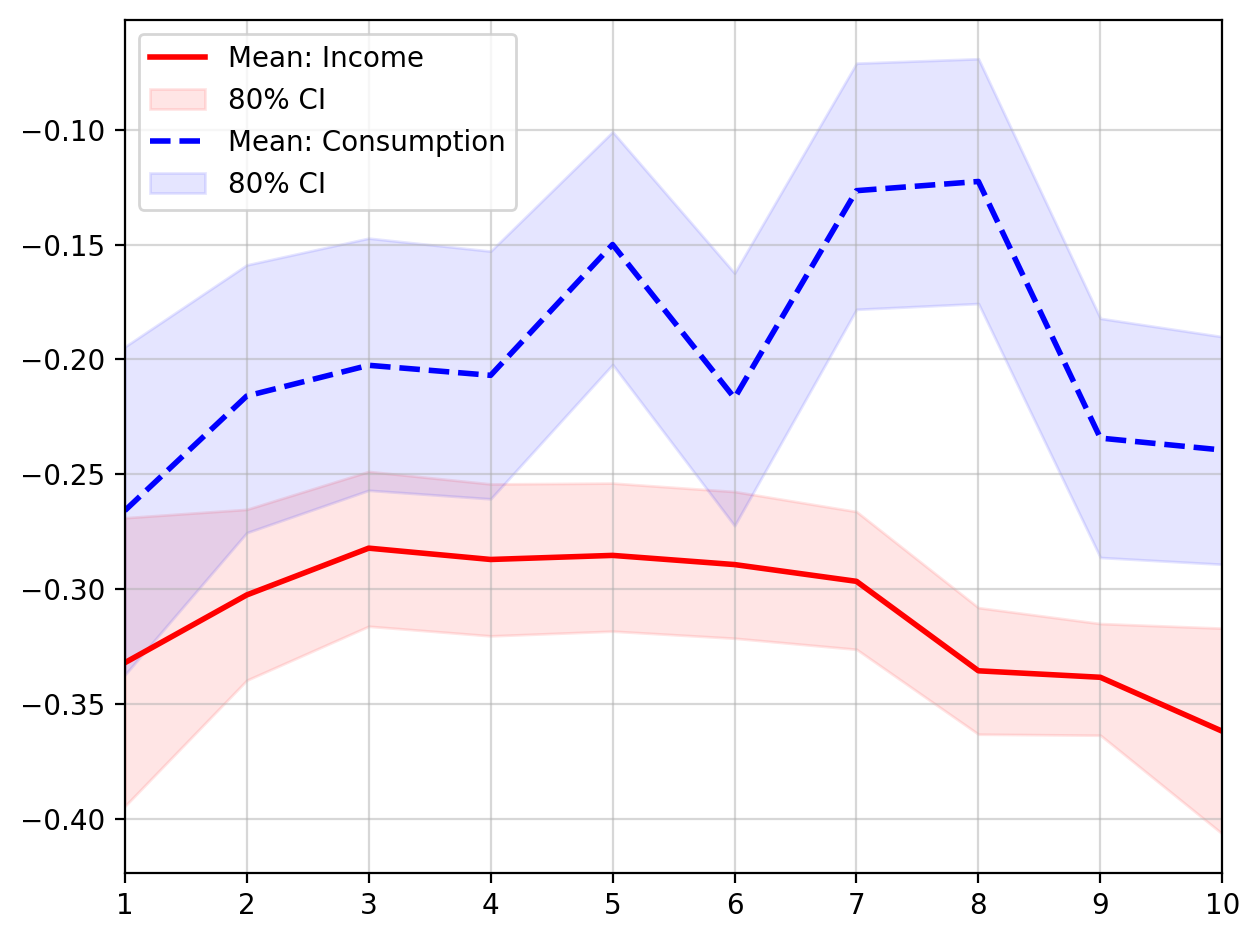

In [98]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

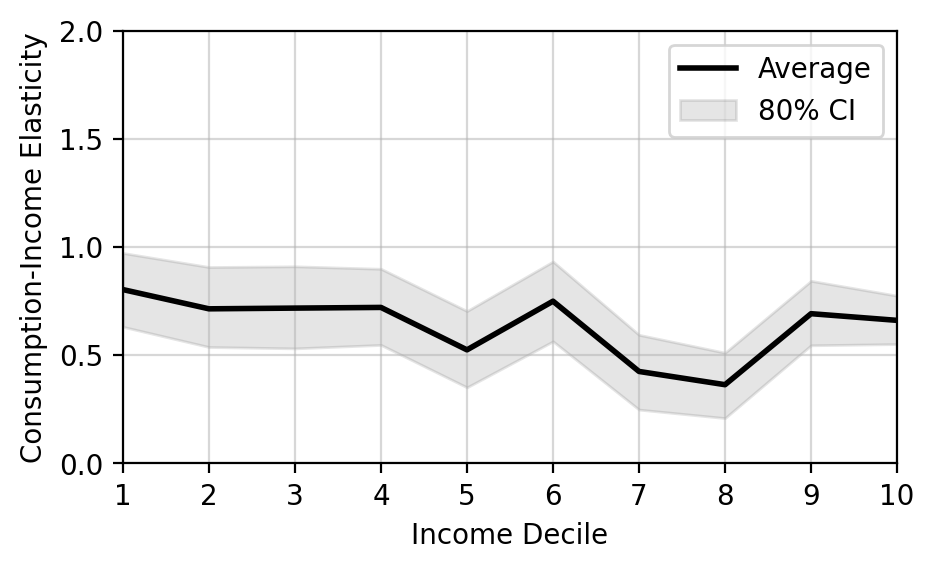

In [99]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure(figsize = mpl.set_size())

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

if save:
    os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)